# Bina.az Monthly Comparison Dashboard

This notebook automatically detects all available monthly data files and compares them.

**Usage:** Just run all cells - it will:
- Auto-detect all months you've scraped (202601, 202602, 202603, etc.)
- Compare prices between consecutive months
- Show trends and changes over time
- Generate comparison charts

**Works with any number of months!**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import re
from datetime import datetime
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (15, 6)
print("✓ Libraries loaded")

✓ Libraries loaded


## 1. Auto-Detect Available Months

In [2]:
# Auto-detect all available months
data_path = Path('data')

# Find all sale CSV files
sale_files = {}
for f in data_path.glob('bina_sale_*.csv'):
    match = re.search(r'(\d{6})', f.name)
    if match:
        month = match.group(1)
        sale_files[month] = f

# Find all rent CSV files
rent_files = {}
rent_path = data_path / 'rent'
if rent_path.exists():
    for f in rent_path.glob('bina_rent_*.csv'):
        match = re.search(r'(\d{6})', f.name)
        if match:
            month = match.group(1)
            rent_files[month] = f

# Display available months
all_months = sorted(set(sale_files.keys()) | set(rent_files.keys()))

print("=" * 60)
print("AVAILABLE MONTHLY DATA")
print("=" * 60)
for month in all_months:
    year = month[:4]
    month_num = month[4:6]
    month_name = datetime.strptime(month, '%Y%m').strftime('%B %Y')
    
    sale_status = "✓" if month in sale_files else "✗"
    rent_status = "✓" if month in rent_files else "✗"
    
    sale_size = f"{sale_files[month].stat().st_size / (1024**2):.0f} MB" if month in sale_files else "N/A"
    rent_size = f"{rent_files[month].stat().st_size / (1024**2):.0f} MB" if month in rent_files else "N/A"
    
    print(f"{month_name:15} | Sale: {sale_status} {sale_size:>8} | Rent: {rent_status} {rent_size:>8}")

print("=" * 60)
print(f"Total months found: {len(all_months)}")
print("=" * 60)

AVAILABLE MONTHLY DATA
January 2026    | Sale: ✓   146 MB | Rent: ✓    52 MB
February 2026   | Sale: ✓    52 MB | Rent: ✗      N/A
Total months found: 2


In [3]:
# Load all available data
sale_data = {}
rent_data = {}

print("\nLoading SALE data...")
for month, filepath in sale_files.items():
    try:
        df = pd.read_csv(filepath)
        df['month'] = month
        sale_data[month] = df
        print(f"  ✓ {month}: {len(df):,} properties")
    except Exception as e:
        print(f"  ✗ {month}: Failed to load - {e}")

print("\nLoading RENT data...")
for month, filepath in rent_files.items():
    try:
        df = pd.read_csv(filepath)
        df['month'] = month
        rent_data[month] = df
        print(f"  ✓ {month}: {len(df):,} properties")
    except Exception as e:
        print(f"  ✗ {month}: Failed to load - {e}")

print(f"\n✓ Loaded {len(sale_data)} sale months and {len(rent_data)} rent months")


Loading SALE data...
  ✓ 202601: 68,915 properties
  ✓ 202602: 24,592 properties

Loading RENT data...
  ✓ 202601: 24,560 properties

✓ Loaded 2 sale months and 1 rent months


## 2. SALE Properties - Multi-Month Comparison

In [4]:
if len(sale_data) > 0:
    # Combine all sale data
    sale_combined = pd.concat(sale_data.values(), ignore_index=True)
    
    print("\n" + "=" * 60)
    print("SALE PROPERTIES - PRICE STATISTICS BY MONTH")
    print("=" * 60)
    
    if 'price' in sale_combined.columns:
        # Statistics by month
        stats = sale_combined.groupby('month')['price'].agg([
            ('count', 'count'),
            ('mean', 'mean'),
            ('median', 'median'),
            ('min', 'min'),
            ('max', 'max')
        ]).sort_index()
        
        # Add month-over-month change
        stats['avg_change'] = stats['mean'].pct_change() * 100
        stats['count_change'] = stats['count'].diff()
        
        print(stats.to_string())
        print("=" * 60)
    else:
        print("Warning: No 'price' column found in data")
        print(f"Available columns: {sale_combined.columns.tolist()}")
else:
    print("No sale data available")


SALE PROPERTIES - PRICE STATISTICS BY MONTH
Available columns: ['id', 'area_value', 'area_units', 'leased', 'floor', 'floors', 'rooms', 'city_id', 'city_name', 'location_id', 'location_name', 'location_full_name', 'price_value', 'price_currency', 'company_id', 'company_name', 'company_target_type', 'has_mortgage', 'has_bill_of_sale', 'has_repair', 'paid_daily', 'is_business', 'vipped', 'featured', 'updated_at', 'path', 'photos_count', 'photos', 'url', 'category', 'scraped_at', 'month']


In [5]:
if len(sale_data) > 0 and 'price' in sale_combined.columns:
    # Month-over-month comparison
    sorted_months = sorted(sale_data.keys())
    
    print("\n" + "=" * 60)
    print("MONTH-OVER-MONTH COMPARISON (SALE)")
    print("=" * 60)
    
    for i in range(1, len(sorted_months)):
        prev_month = sorted_months[i-1]
        curr_month = sorted_months[i]
        
        prev_df = sale_data[prev_month]
        curr_df = sale_data[curr_month]
        
        prev_name = datetime.strptime(prev_month, '%Y%m').strftime('%B %Y')
        curr_name = datetime.strptime(curr_month, '%Y%m').strftime('%B %Y')
        
        if 'price' in prev_df.columns and 'price' in curr_df.columns:
            prev_avg = prev_df['price'].mean()
            curr_avg = curr_df['price'].mean()
            price_change = ((curr_avg - prev_avg) / prev_avg * 100) if prev_avg > 0 else 0
            
            prev_count = len(prev_df)
            curr_count = len(curr_df)
            count_change = curr_count - prev_count
            count_pct = (count_change / prev_count * 100) if prev_count > 0 else 0
            
            print(f"\n{prev_name} → {curr_name}:")
            print(f"  Listings:    {prev_count:,} → {curr_count:,} ({count_change:+,} / {count_pct:+.1f}%)")
            print(f"  Avg Price:   {prev_avg:,.0f} → {curr_avg:,.0f} ({price_change:+.2f}%)")
            print(f"  Median:      {prev_df['price'].median():,.0f} → {curr_df['price'].median():,.0f}")
    
    print("=" * 60)

In [6]:
if len(sale_data) > 0 and 'price' in sale_combined.columns:
    # Price trends visualization
    sorted_months = sorted(sale_data.keys())
    month_labels = [datetime.strptime(m, '%Y%m').strftime('%b %y') for m in sorted_months]
    
    avg_prices = [sale_data[m]['price'].mean() for m in sorted_months]
    median_prices = [sale_data[m]['price'].median() for m in sorted_months]
    listing_counts = [len(sale_data[m]) for m in sorted_months]
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Average prices trend
    axes[0].plot(month_labels, avg_prices, marker='o', linewidth=2, markersize=8, color='#1f77b4')
    axes[0].set_title('Average Sale Price Trend', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('Average Price', fontsize=11)
    axes[0].set_xlabel('Month', fontsize=11)
    axes[0].grid(True, alpha=0.3)
    axes[0].tick_params(axis='x', rotation=45)
    for i, v in enumerate(avg_prices):
        axes[0].text(i, v, f'{v:,.0f}', ha='center', va='bottom', fontsize=9)
    
    # Median prices trend
    axes[1].plot(month_labels, median_prices, marker='s', linewidth=2, markersize=8, color='#ff7f0e')
    axes[1].set_title('Median Sale Price Trend', fontsize=14, fontweight='bold')
    axes[1].set_ylabel('Median Price', fontsize=11)
    axes[1].set_xlabel('Month', fontsize=11)
    axes[1].grid(True, alpha=0.3)
    axes[1].tick_params(axis='x', rotation=45)
    for i, v in enumerate(median_prices):
        axes[1].text(i, v, f'{v:,.0f}', ha='center', va='bottom', fontsize=9)
    
    # Listing counts
    axes[2].bar(month_labels, listing_counts, color='#2ca02c', alpha=0.7)
    axes[2].set_title('Total Sale Listings', fontsize=14, fontweight='bold')
    axes[2].set_ylabel('Number of Listings', fontsize=11)
    axes[2].set_xlabel('Month', fontsize=11)
    axes[2].tick_params(axis='x', rotation=45)
    for i, v in enumerate(listing_counts):
        axes[2].text(i, v, f'{v:,}', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.savefig('charts/sale_trend.png', dpi=100, bbox_inches='tight')
    plt.show()
    print("✓ Chart saved to charts/sale_trend.png")

## 3. RENT Properties - Multi-Month Comparison

In [7]:
if len(rent_data) > 0:
    # Combine all rent data
    rent_combined = pd.concat(rent_data.values(), ignore_index=True)
    
    print("\n" + "=" * 60)
    print("RENT PROPERTIES - PRICE STATISTICS BY MONTH")
    print("=" * 60)
    
    if 'price' in rent_combined.columns:
        # Statistics by month
        stats = rent_combined.groupby('month')['price'].agg([
            ('count', 'count'),
            ('mean', 'mean'),
            ('median', 'median'),
            ('min', 'min'),
            ('max', 'max')
        ]).sort_index()
        
        # Add month-over-month change
        stats['avg_change'] = stats['mean'].pct_change() * 100
        stats['count_change'] = stats['count'].diff()
        
        print(stats.to_string())
        print("=" * 60)
        
        # Month-over-month comparison
        sorted_months = sorted(rent_data.keys())
        
        if len(sorted_months) > 1:
            print("\n" + "=" * 60)
            print("MONTH-OVER-MONTH COMPARISON (RENT)")
            print("=" * 60)
            
            for i in range(1, len(sorted_months)):
                prev_month = sorted_months[i-1]
                curr_month = sorted_months[i]
                
                prev_df = rent_data[prev_month]
                curr_df = rent_data[curr_month]
                
                prev_name = datetime.strptime(prev_month, '%Y%m').strftime('%B %Y')
                curr_name = datetime.strptime(curr_month, '%Y%m').strftime('%B %Y')
                
                if 'price' in prev_df.columns and 'price' in curr_df.columns:
                    prev_avg = prev_df['price'].mean()
                    curr_avg = curr_df['price'].mean()
                    price_change = ((curr_avg - prev_avg) / prev_avg * 100) if prev_avg > 0 else 0
                    
                    prev_count = len(prev_df)
                    curr_count = len(curr_df)
                    count_change = curr_count - prev_count
                    count_pct = (count_change / prev_count * 100) if prev_count > 0 else 0
                    
                    print(f"\n{prev_name} → {curr_name}:")
                    print(f"  Listings:    {prev_count:,} → {curr_count:,} ({count_change:+,} / {count_pct:+.1f}%)")
                    print(f"  Avg Rent:    {prev_avg:,.0f} → {curr_avg:,.0f} ({price_change:+.2f}%)")
                    print(f"  Median:      {prev_df['price'].median():,.0f} → {curr_df['price'].median():,.0f}")
            
            print("=" * 60)
    else:
        print("Warning: No 'price' column found in data")
        print(f"Available columns: {rent_combined.columns.tolist()}")
else:
    print("No rent data available")


RENT PROPERTIES - PRICE STATISTICS BY MONTH
Available columns: ['id', 'area_value', 'area_units', 'leased', 'floor', 'floors', 'rooms', 'city_id', 'city_name', 'location_id', 'location_name', 'location_full_name', 'price_value', 'price_currency', 'company_id', 'company_name', 'company_target_type', 'has_mortgage', 'has_bill_of_sale', 'has_repair', 'paid_daily', 'is_business', 'vipped', 'featured', 'updated_at', 'path', 'photos_count', 'photos', 'url', 'category', 'scraped_at', 'month']


In [8]:
if len(rent_data) > 0 and 'price' in rent_combined.columns:
    # Rent trends visualization
    sorted_months = sorted(rent_data.keys())
    month_labels = [datetime.strptime(m, '%Y%m').strftime('%b %y') for m in sorted_months]
    
    avg_rents = [rent_data[m]['price'].mean() for m in sorted_months]
    median_rents = [rent_data[m]['price'].median() for m in sorted_months]
    listing_counts = [len(rent_data[m]) for m in sorted_months]
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Average rent trend
    axes[0].plot(month_labels, avg_rents, marker='o', linewidth=2, markersize=8, color='#d62728')
    axes[0].set_title('Average Monthly Rent Trend', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('Average Rent', fontsize=11)
    axes[0].set_xlabel('Month', fontsize=11)
    axes[0].grid(True, alpha=0.3)
    axes[0].tick_params(axis='x', rotation=45)
    for i, v in enumerate(avg_rents):
        axes[0].text(i, v, f'{v:,.0f}', ha='center', va='bottom', fontsize=9)
    
    # Median rent trend
    axes[1].plot(month_labels, median_rents, marker='s', linewidth=2, markersize=8, color='#9467bd')
    axes[1].set_title('Median Monthly Rent Trend', fontsize=14, fontweight='bold')
    axes[1].set_ylabel('Median Rent', fontsize=11)
    axes[1].set_xlabel('Month', fontsize=11)
    axes[1].grid(True, alpha=0.3)
    axes[1].tick_params(axis='x', rotation=45)
    for i, v in enumerate(median_rents):
        axes[1].text(i, v, f'{v:,.0f}', ha='center', va='bottom', fontsize=9)
    
    # Listing counts
    axes[2].bar(month_labels, listing_counts, color='#8c564b', alpha=0.7)
    axes[2].set_title('Total Rent Listings', fontsize=14, fontweight='bold')
    axes[2].set_ylabel('Number of Listings', fontsize=11)
    axes[2].set_xlabel('Month', fontsize=11)
    axes[2].tick_params(axis='x', rotation=45)
    for i, v in enumerate(listing_counts):
        axes[2].text(i, v, f'{v:,}', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.savefig('charts/rent_trend.png', dpi=100, bbox_inches='tight')
    plt.show()
    print("✓ Chart saved to charts/rent_trend.png")

## 4. Combined Market Overview - All Months

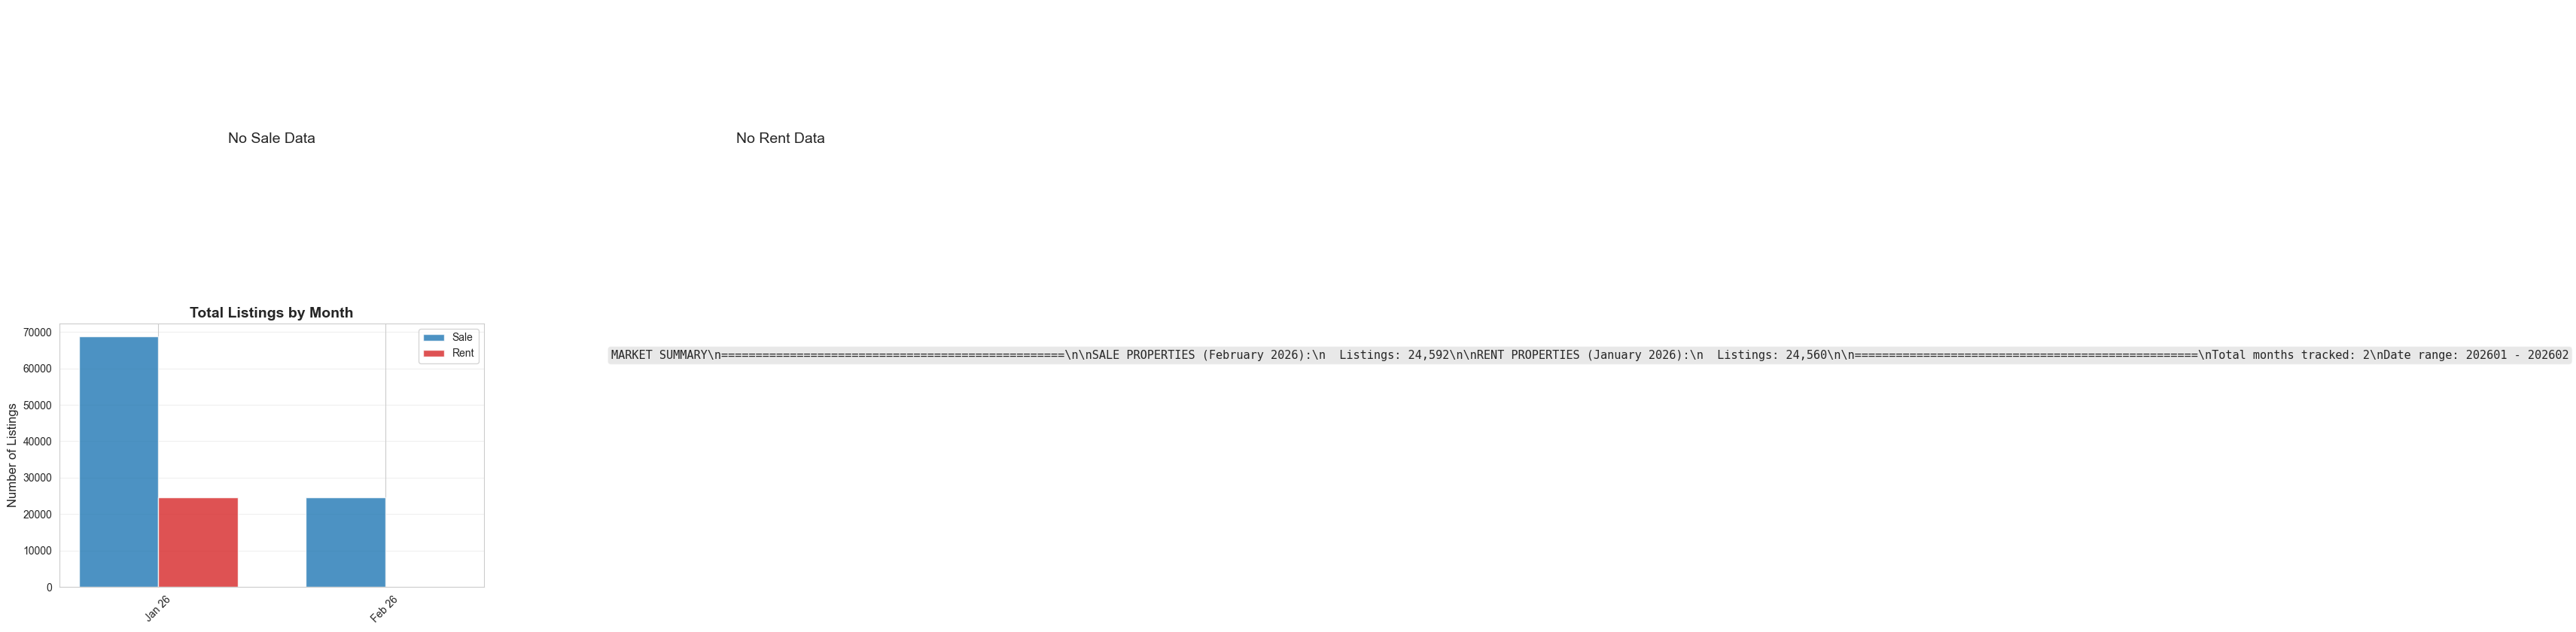

✓ Chart saved to charts/combined_overview.png
\n============================================================
✓ ANALYSIS COMPLETE


In [9]:
# Combined comparison chart for both sale and rent
if len(sale_data) > 0 or len(rent_data) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    
    # Sale prices over time
    if len(sale_data) > 0 and 'price' in sale_combined.columns:
        sorted_months = sorted(sale_data.keys())
        month_labels = [datetime.strptime(m, '%Y%m').strftime('%b %y') for m in sorted_months]
        avg_prices = [sale_data[m]['price'].mean() for m in sorted_months]
        
        axes[0,0].plot(month_labels, avg_prices, marker='o', linewidth=3, markersize=10, color='#1f77b4', label='Sale Avg Price')
        axes[0,0].fill_between(range(len(month_labels)), avg_prices, alpha=0.3, color='#1f77b4')
        axes[0,0].set_title('SALE - Average Price Trend', fontsize=14, fontweight='bold')
        axes[0,0].set_ylabel('Price', fontsize=12)
        axes[0,0].grid(True, alpha=0.3)
        axes[0,0].tick_params(axis='x', rotation=45)
        for i, v in enumerate(avg_prices):
            axes[0,0].text(i, v, f'{v:,.0f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    else:
        axes[0,0].text(0.5, 0.5, 'No Sale Data', ha='center', va='center', transform=axes[0,0].transAxes, fontsize=14)
        axes[0,0].axis('off')
    
    # Rent prices over time
    if len(rent_data) > 0 and 'price' in rent_combined.columns:
        sorted_months = sorted(rent_data.keys())
        month_labels = [datetime.strptime(m, '%Y%m').strftime('%b %y') for m in sorted_months]
        avg_rents = [rent_data[m]['price'].mean() for m in sorted_months]
        
        axes[0,1].plot(month_labels, avg_rents, marker='o', linewidth=3, markersize=10, color='#d62728', label='Rent Avg Price')
        axes[0,1].fill_between(range(len(month_labels)), avg_rents, alpha=0.3, color='#d62728')
        axes[0,1].set_title('RENT - Average Price Trend', fontsize=14, fontweight='bold')
        axes[0,1].set_ylabel('Monthly Rent', fontsize=12)
        axes[0,1].grid(True, alpha=0.3)
        axes[0,1].tick_params(axis='x', rotation=45)
        for i, v in enumerate(avg_rents):
            axes[0,1].text(i, v, f'{v:,.0f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    else:
        axes[0,1].text(0.5, 0.5, 'No Rent Data', ha='center', va='center', transform=axes[0,1].transAxes, fontsize=14)
        axes[0,1].axis('off')
    
    # Listing counts comparison
    if len(sale_data) > 0:
        sorted_months = sorted(sale_data.keys())
        month_labels = [datetime.strptime(m, '%Y%m').strftime('%b %y') for m in sorted_months]
        sale_counts = [len(sale_data[m]) for m in sorted_months]
        
        x = np.arange(len(month_labels))
        width = 0.35
        
        axes[1,0].bar(x - width/2, sale_counts, width, label='Sale', color='#1f77b4', alpha=0.8)
        
        if len(rent_data) > 0:
            rent_months = sorted(rent_data.keys())
            rent_counts = [len(rent_data[m]) if m in rent_data else 0 for m in sorted_months]
            axes[1,0].bar(x + width/2, rent_counts, width, label='Rent', color='#d62728', alpha=0.8)
        
        axes[1,0].set_title('Total Listings by Month', fontsize=14, fontweight='bold')
        axes[1,0].set_ylabel('Number of Listings', fontsize=12)
        axes[1,0].set_xticks(x)
        axes[1,0].set_xticklabels(month_labels, rotation=45)
        axes[1,0].legend()
        axes[1,0].grid(True, alpha=0.3, axis='y')
    
    # Summary statistics table
    axes[1,1].axis('off')
    summary_text = "MARKET SUMMARY\\n" + "=" * 50 + "\\n\\n"
    
    if len(sale_data) > 0:
        latest_sale_month = max(sale_data.keys())
        latest_sale_name = datetime.strptime(latest_sale_month, '%Y%m').strftime('%B %Y')
        latest_sale_df = sale_data[latest_sale_month]
        
        summary_text += f"SALE PROPERTIES ({latest_sale_name}):\\n"
        summary_text += f"  Listings: {len(latest_sale_df):,}\\n"
        if 'price' in latest_sale_df.columns:
            summary_text += f"  Avg Price: {latest_sale_df['price'].mean():,.0f}\\n"
            summary_text += f"  Median: {latest_sale_df['price'].median():,.0f}\\n"
        summary_text += "\\n"
    
    if len(rent_data) > 0:
        latest_rent_month = max(rent_data.keys())
        latest_rent_name = datetime.strptime(latest_rent_month, '%Y%m').strftime('%B %Y')
        latest_rent_df = rent_data[latest_rent_month]
        
        summary_text += f"RENT PROPERTIES ({latest_rent_name}):\\n"
        summary_text += f"  Listings: {len(latest_rent_df):,}\\n"
        if 'price' in latest_rent_df.columns:
            summary_text += f"  Avg Rent: {latest_rent_df['price'].mean():,.0f}\\n"
            summary_text += f"  Median: {latest_rent_df['price'].median():,.0f}\\n"
        summary_text += "\\n"
    
    summary_text += "=" * 50 + "\\n"
    summary_text += f"Total months tracked: {len(all_months)}\\n"
    summary_text += f"Date range: {min(all_months)} - {max(all_months)}"
    
    axes[1,1].text(0.1, 0.9, summary_text, transform=axes[1,1].transAxes, 
                   fontsize=11, verticalalignment='top', family='monospace',
                   bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.5))
    
    plt.tight_layout()
    plt.savefig('charts/combined_overview.png', dpi=100, bbox_inches='tight')
    plt.show()
    print("✓ Chart saved to charts/combined_overview.png")

print("\\n" + "=" * 60)
print("✓ ANALYSIS COMPLETE")
print("=" * 60)